In [1]:
!pip install -Uqq fastbook

In [2]:
import fastbook
fastbook.setup_book()
from fastai.vision.data import ImageDataLoaders
from fastai.vision.all import *
from fastai.imports import *
import gc 
import pandas as pd
import seaborn as sns
import os
import json
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
sns.set_theme()
import PIL
from PIL import Image
%matplotlib inline

In [3]:
model = load_learner('gdrive/MyDrive/AML_Project/subsampled_data/single_item_images/export-final-resnet50.pkl')

In [4]:
images = []
output = []
for image in os.listdir('gdrive/MyDrive/AML_Project/test/image'):
  output.append(model.predict('gdrive/MyDrive/AML_Project/test/image/' + image)[0])
  images.append(image)
df2 = pd.DataFrame({'Image': images, 'Output': output})

In [5]:
df_list=[]
directory = 'gdrive/MyDrive/AML_Project/test/json'
item_per_sample = []
for file in os.listdir(directory):
    filename = os.fsdecode(file)
    if filename.endswith(".json"):
        loc=os.path.join(directory, filename)
        with open(loc,'r') as myfile:
            data=myfile.read()
        obj=json.loads(data)
        pair_id=obj['pair_id']
        source=obj['source']
        keys_obj = obj.keys()
        filtered_items = [item for item in keys_obj if item.startswith('item')]   
        i = 1
        item_counter = 0
        while(i<=len(filtered_items)):
            try:
                clothing=obj['item{}'.format(str(i))]['category_name']
                bounding_box_vals=obj['item{}'.format(str(i))]['bounding_box']
                scale=obj['item{}'.format(str(i))]['scale']
                viewpoint=obj['item{}'.format(str(i))]['viewpoint']
                zoom=obj['item{}'.format(str(i))]['zoom_in']
                occlusion=obj['item{}'.format(str(i))]['occlusion']
                df_list.append([filename, pair_id, source, clothing, bounding_box_vals, scale, viewpoint, zoom, occlusion])
                item_counter+=1
                i+=1
            except:
                break
        item_per_sample.append(item_counter)
df = pd.DataFrame(df_list, columns=['filename', 'Pair Id', 'Source', 'Clothing','Box','scale','viewpoint','zoom','occlusion'])

In [6]:
temp = []
for x in df['filename'].str.split('.'):
  temp.append(x[0])
df['file'] = temp

In [7]:
temp = []
for x in df2['Image'].str.split('.'):
  temp.append(x[0])
df2['file'] = temp

In [8]:
df_final = df.merge(df2, on = 'file')

In [9]:
df_final[df_final['Clothing'] == df_final['Output']]['Clothing']

1            trousers
2          vest dress
4    short sleeve top
Name: Clothing, dtype: object

In [10]:
similarity = pd.read_csv('gdrive/MyDrive/AML_Project/test/similarity.csv')
similarity = similarity.set_index('Unnamed: 0')
similarity.index.name = None

In [11]:
upper_half = ["short sleeve top", "long sleeve top", "vest", "long sleeve outwear", "sling", "short sleeve outwear"]
lower_half = ["trousers", "shorts", "skirt"]
dress = ["vest dress", "short sleeve dress", "long sleeve dress", "sling dress"]

In [12]:
def label_grouping(row):
    clothing_label = row["type"]
    if clothing_label in  upper_half :
        return 'Upper_Half'
    if clothing_label in  lower_half :
        return 'Lower_Half'
    else:
        return 'Dress'

In [13]:
def get_recommendation(x):
    df_temp = pd.DataFrame(similarity[x]).reset_index()
    df_temp.columns = ['type', 'score']
    df_temp['group'] = df_temp.apply(lambda row: label_grouping(row), axis = 1)
    x_type = label_grouping({'type': x})
    if x_type == 'Upper_Half':
        df_temp = df_temp[df_temp['group'] == 'Lower_Half']
        df_temp.set_index('type', inplace = True)
        pred = df_temp['score'].idxmax()
    elif x_type == 'Lower_Half':
        df_temp = df_temp[df_temp['group'] == 'Upper_Half']
        df_temp.set_index('type', inplace = True)
        pred = df_temp['score'].idxmax()
    else:
        df_temp = df_temp[df_temp['type'].isin(["long sleeve outwear", "short sleeve outwear"])]
        df_temp.set_index('type', inplace = True)
        pred = df_temp['score'].idxmax()
    return pred

In [14]:
recs = []
for x in df_final['Output']:
    recs.append(get_recommendation(x))
df_final['Recommendation'] = recs

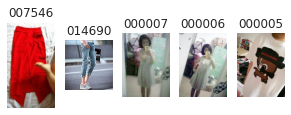

In [15]:
files = os.listdir('gdrive/MyDrive/AML_Project/test/image')
rows = 2
for num, x in enumerate(files):
    img = PIL.Image.open('gdrive/MyDrive/AML_Project/test/image/' + x)
    plt.subplot(rows,6,num+1)
    plt.title(x.split('.')[0])
    plt.axis('off')
    plt.imshow(img)

In [16]:
df_final = df_final[['filename', 'Clothing', 'Output', 'Recommendation']]
df_final.columns = ['filename', 'Actual', 'Prediction', 'Recommendation']
df_final

,filename,Actual,Prediction,Recommendation
0,007546.json,skirt,short sleeve dress,long sleeve outwear
1,014690.json,trousers,trousers,sling
2,000007.json,vest dress,vest dress,long sleeve outwear
3,000006.json,vest dress,short sleeve dress,long sleeve outwear
4,000005.json,short sleeve top,short sleeve top,shorts
